In [ ]:
import sys
import os

# Get parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add parent directory to sys.path
sys.path.append(parent_dir)

In [16]:
import re
import math
import json
import random
from loaders import ItemLoader
from config import DATASET_FOLDER, SEED, OPENAI_API_KEY, ANTHROPIC_API_KEY
from utils import Utils
from testing import Tester
import openai
import anthropic

In [17]:
util = Utils()
openai.api_key = OPENAI_API_KEY
claude = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [8]:
# load train and test sets
loader = ItemLoader()
train, test = loader.load_pickle(folder_name=DATASET_FOLDER)

In [4]:
fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

In [5]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]
    
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\n1970 Ford Bronco\nBeach Ready Bronco 4x4 Restomod by Velocity Restorations The Velocity 1970 Ford Bronco Ranger Package is a head-turning classic that has been reborn and reimagined with fresh coastal vibes and rugged appeal. Balancing retro aesthetics with modern strength, this vintage Ford Bronco restomod blends the best of yesterday and today in every inch of its design. Wrapped in a dazzling two-tone Light Jade over Wimbledon White, this Bronco captures the essence of vintage adventure with the unmistakable charm of the Ranger Package. The exterior's retro stripes and two-tone color scheme are complemented by 33-inch Cooper tires and 17-inch painted steel wheels, giving the Bronco a vintage feel and a sturdy presence on any terrain. The interior continues the theme of elegance and refinement, featuring Velocity's ex

In [6]:
# # convert the items into a list of json objects
# def make_jsonl(items):
#     result = ""
#     for item in items:
#         messages = messages_for(item)
#         messages_str = json.dumps(messages)
#         result += '{"messages": ' + messages_str +'}\n'
#     return result.strip()

# print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\n1970 Ford Bronco\nBeach Ready Bronco 4x4 Restomod by Velocity Restorations The Velocity 1970 Ford Bronco Ranger Package is a head-turning classic that has been reborn and reimagined with fresh coastal vibes and rugged appeal. Balancing retro aesthetics with modern strength, this vintage Ford Bronco restomod blends the best of yesterday and today in every inch of its design. Wrapped in a dazzling two-tone Light Jade over Wimbledon White, this Bronco captures the essence of vintage adventure with the unmistakable charm of the Ranger Package. The exterior's retro stripes and two-tone color scheme are complemented by 33-inch Cooper tires and 17-inch painted steel wheels, giving the Bronco a vintage feel and a sturdy presence on any terrain. The interior continues the theme of elegance and refinement, featuring Veloc

In [7]:
# # Convert the items into jsonl and write them to a file

# def write_jsonl(items, filename):
#     with open(filename, "w") as f:
#         jsonl = make_jsonl(items)
#         f.write(jsonl)

In [13]:
# write jsonl to files in finetune folder
util.write_jsonl(items=fine_tune_val_full, prompt=messages_for, folder_name="finetune", file_name="fine_tune_train.jsonl")
util.write_jsonl(items=fine_tune_val_full, prompt=messages_for, folder_name="finetune", file_name="fine_tune_validation.jsonl")

In [14]:
# write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [8]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [9]:
train_file

FileObject(id='file-N5d8hGepa9BgE2ihGMigtD', bytes=440857, created_at=1740194018, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [10]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [11]:
validation_file

FileObject(id='file-4x6N15Y1kjak98iTQp8jzr', bytes=108410, created_at=1740194022, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

## Fine-tune GPT 4o mini on 200 examples

In [12]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [20]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=SEED,
    integrations = [wandb_integration],
    suffix="car-pricer"
)

FineTuningJob(id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO', created_at=1739836477, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-HNzsWQKJTH2m9etEPNf5Bw', validation_file='file-Am8V1muvPf7pZuyCnXY32F', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 'auto'}}})

In [21]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO', created_at=1739836477, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-HNzsWQKJTH2m9etEPNf5Bw', validation_file='file-Am8V1muvPf7pZuyCnXY32F', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 3, 'batch_size': 1, 'learning_rate_multiplier': 1.8}}})], object='list', has_more=False)

In [22]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
job_id

'ftjob-gMb4ejKgZQ1hdhaNisTzvBKO'

In [24]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-Mi7MIpj0MDSiU2j5PgsnPPWD', created_at=1739836859, level='info', message='Step 101/600: training loss=1.39', object='fine_tuning.job.event', data={'step': 101, 'train_loss': 1.3918516635894775, 'total_steps': 600, 'train_mean_token_accuracy': 0.7777777910232544}, type='metrics'),
 FineTuningJobEvent(id='ftevent-1p1IPE1AsuxJPlqdC9DxIBZy', created_at=1739836857, level='info', message='Step 100/600: training loss=0.40, validation loss=0.96', object='fine_tuning.job.event', data={'step': 100, 'train_loss': 0.4039156138896942, 'valid_loss': 0.9621259901258681, 'total_steps': 600, 'train_mean_token_accuracy': 0.7777777910232544, 'valid_mean_token_accuracy': 0.7777777777777778}, type='metrics'),
 FineTuningJobEvent(id='ftevent-SGI7nwUg0QGfocn7qiSdfzmr', created_at=1739836854, level='info', message='Step 99/600: training loss=0.66', object='fine_tuning.job.event', data={'step': 99, 'train_loss': 0.6636986136436462, 'total_steps': 600, 'train_mean_token_accuracy':

In [25]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO', created_at=1739836477, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-HNzsWQKJTH2m9etEPNf5Bw', validation_file='file-Am8V1muvPf7pZuyCnXY32F', estimated_finish=1739837540, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-gMb4ejKgZQ1hdhaNisTzvBKO'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 3, 'batch_size': 1, 'learning_rate_multiplier': 1.8}}})

In [28]:
# get fine-tuned model
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:car-pricer:B25WBkGV'

In [10]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]
    
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\n1969 Chevrolet Camaro\n1969 Chevrolet Camaro SS Convertible. 396 Automatic Body off restoration. Documented matching numbers. Original documents include. Protection plate, original title. Original invoice and more. Rated #1 show quality. Options PS PB Power Top Rear shoulder seat belts. No AC -Vehicle is on consignment and at our clients home -Please Call First and talk to a rep at EXT 1 -Showroom is by appointment only Please Call -If you would like a FREE Listing please visit our consignment page or Call Category 1969_chevrolet_camaro'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [6]:
# utility function to extract price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [23]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=SEED,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $98,900.00 Truth: $102,995.00 Error: $4,095.00 SLE: 0.00 Item: 1969 Chevrolet Camaro
2: Guess: $56,995.00 Truth: $39,995.00 Error: $17,000.00 SLE: 0.13 Item: 1967 Chevrolet Camaro
3: Guess: $12,000.00 Truth: $12,950.00 Error: $950.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
4: Guess: $135,000.00 Truth: $115,000.00 Error: $20,000.00 SLE: 0.03 Item: 1968 Chevrolet Camaro SS
5: Guess: $139,995.00 Truth: $125,000.00 Error: $14,995.00 SLE: 0.01 Item: 1967 Ford Mustang
6: Guess: $59,995.00 Truth: $65,000.00 Error: $5,005.00 SLE: 0.01 Item: 1966 Ford Mustang
7: Guess: $66,995.00 Truth: $57,995.00 Error: $9,000.00 SLE: 0.02 Item: 1967 Chevrolet Camaro
8: Guess: $49,500.00 Truth: $49,500.00 Error: $0.00 SLE: 0.00 Item: 1975 Ford Bronco
9: Guess: $59,900.00 Truth: $64,900.00 Error: $5,000.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
10: Guess: $36,000.00 Truth: $36,000.00 Error: $0.00 SLE: 0.00 Item: 1967 Ford Bronco
11: Guess: $69,950.00 Truth: $44,950.00 Error: $25,000.00 SLE: 0.20 Item: 19

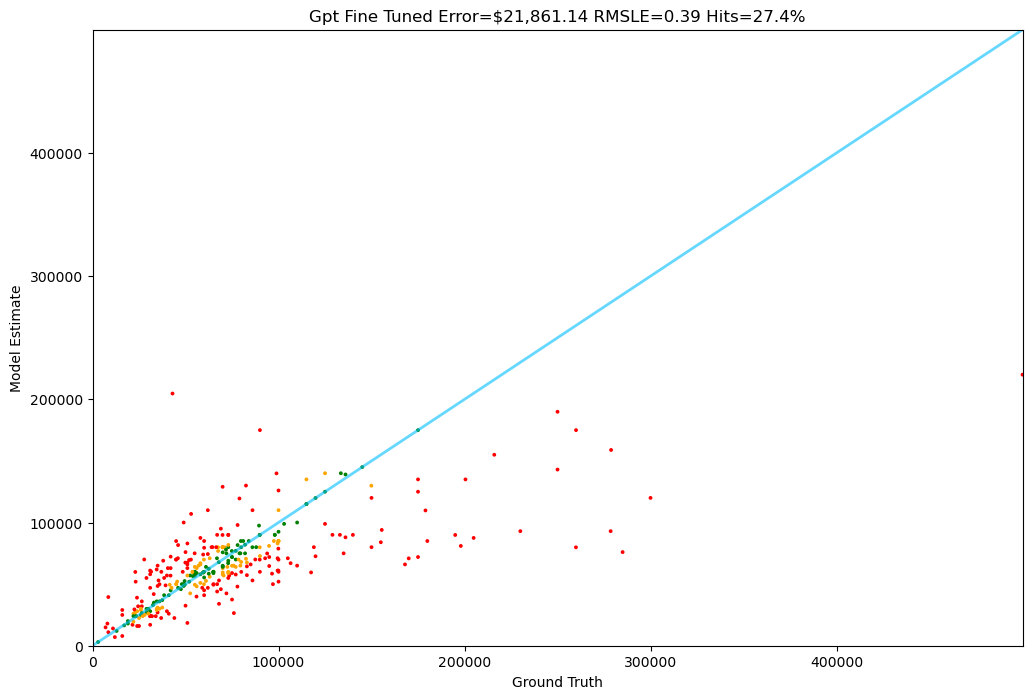

In [24]:
Tester.test(gpt_fine_tuned, test)

## Fine-tune GPT 4o on 200 examples

In [13]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-2024-08-06",
    seed=SEED,
    integrations = [wandb_integration],
    suffix="car-pricer"
)

FineTuningJob(id='ftjob-9pZYrU0qc7h0dr0RPEeS43Ha', created_at=1740195115, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-N5d8hGepa9BgE2ihGMigtD', validation_file='file-4x6N15Y1kjak98iTQp8jzr', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-9pZYrU0qc7h0dr0RPEeS43Ha'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 'auto'}}})

In [16]:
job_id = 'ftjob-9pZYrU0qc7h0dr0RPEeS43Ha'
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-hMJulXmy4PG6mL0h1WZdq8H7', created_at=1740196246, level='info', message='Step 301/600: training loss=0.64', object='fine_tuning.job.event', data={'step': 301, 'train_loss': 0.6350048780441284, 'total_steps': 600, 'train_mean_token_accuracy': 0.8888888955116272}, type='metrics'),
 FineTuningJobEvent(id='ftevent-09jA32Ku5apOgskjAbopthdo', created_at=1740196239, level='info', message='Step 300/600: training loss=0.42, validation loss=0.61', object='fine_tuning.job.event', data={'step': 300, 'train_loss': 0.41883721947669983, 'valid_loss': 0.6083475748697916, 'total_steps': 600, 'train_mean_token_accuracy': 0.8888888955116272, 'valid_mean_token_accuracy': 0.8888888888888888}, type='metrics'),
 FineTuningJobEvent(id='ftevent-klzS0zD8nFsDC4RvSXOGN4vo', created_at=1740196234, level='info', message='Step 299/600: training loss=1.66', object='fine_tuning.job.event', data={'step': 299, 'train_loss': 1.6566789150238037, 'total_steps': 600, 'train_mean_token_accurac

In [19]:
# get fine-tuned model
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-2024-08-06:personal:car-pricer:B3b3CyhO'

'ftjob-9pZYrU0qc7h0dr0RPEeS43Ha'

In [21]:
# Testing block functions

# The prompt
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

# utility function to extract price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

# The function for gpt-4o-mini
def gpt_4o_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=SEED,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $94,999.00 Truth: $102,995.00 Error: $7,996.00 SLE: 0.01 Item: 1969 Chevrolet Camaro
2: Guess: $49,995.00 Truth: $39,995.00 Error: $10,000.00 SLE: 0.05 Item: 1967 Chevrolet Camaro
3: Guess: $12,000.00 Truth: $12,950.00 Error: $950.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
4: Guess: $159,995.00 Truth: $115,000.00 Error: $44,995.00 SLE: 0.11 Item: 1968 Chevrolet Camaro SS
5: Guess: $99,495.00 Truth: $125,000.00 Error: $25,505.00 SLE: 0.05 Item: 1967 Ford Mustang
6: Guess: $44,995.00 Truth: $65,000.00 Error: $20,005.00 SLE: 0.14 Item: 1966 Ford Mustang
7: Guess: $69,995.00 Truth: $57,995.00 Error: $12,000.00 SLE: 0.04 Item: 1967 Chevrolet Camaro
8: Guess: $49,500.00 Truth: $49,500.00 Error: $0.00 SLE: 0.00 Item: 1975 Ford Bronco
9: Guess: $59,999.00 Truth: $64,900.00 Error: $4,901.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
10: Guess: $36,000.00 Truth: $36,000.00 Error: $0.00 SLE: 0.00 Item: 1967 Ford Bronco
11: Guess: $94,950.00 Truth: $44,950.00 Error: $50,000.00 SLE: 0.56 Item: 1

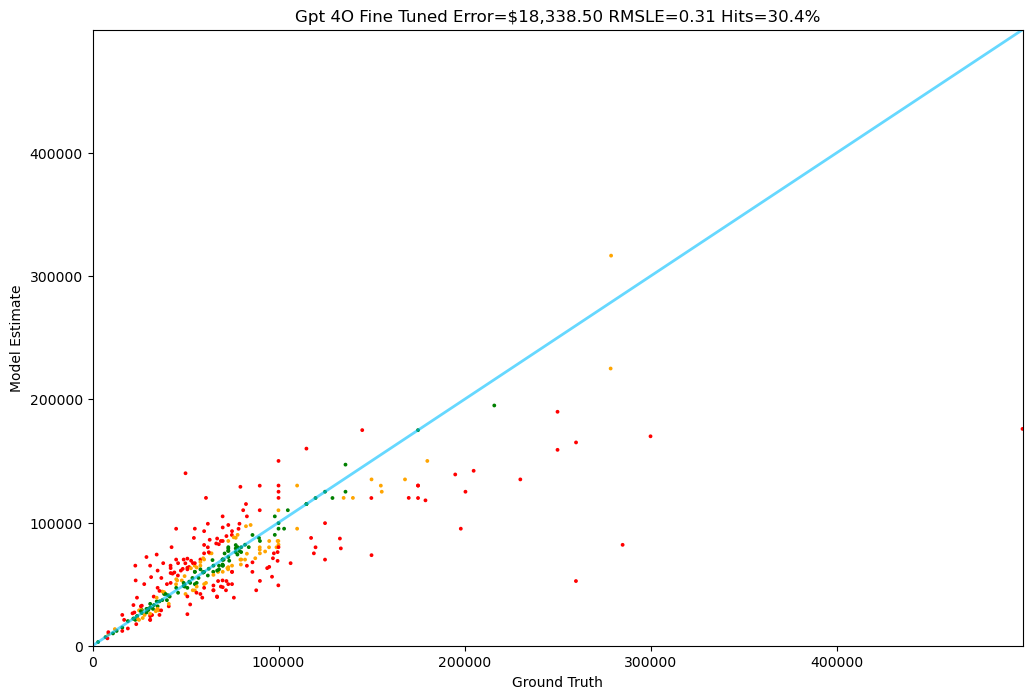

In [22]:
Tester.test(gpt_4o_fine_tuned, test)

## Fine-tune GPT 4o mini on full training set

In [25]:
fine_tune_train_full = train[:1300]
fine_tune_val_full = train[1300:]

In [6]:
util.write_jsonl(items=fine_tune_train_full, prompt=messages_for, folder_name="finetune", file_name="fine_tune_train_full.jsonl")

In [7]:
util.write_jsonl(items=fine_tune_val_full, prompt=messages_for, folder_name="finetune", file_name="fine_tune_validation_full.jsonl")

In [26]:
full_train_file = util.load_jsonl(folder_name="finetune", file_name="fine_tune_train_full.jsonl")
full_val_file = util.load_jsonl(folder_name="finetune", file_name="fine_tune_validation_full.jsonl")

In [11]:
openai.fine_tuning.jobs.create(
    training_file=full_train_file.id,
    validation_file=full_val_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=SEED,
    integrations = [wandb_integration],
    suffix="car-pricer"
)

FineTuningJob(id='ftjob-3AYxBSK7TsajGjDBHEgWe3jC', created_at=1739860266, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-44Yy6bJNZ8rGLsSLbaNcZR', validation_file='file-4uhXAYx4rmHcBkPVzBoxad', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3AYxBSK7TsajGjDBHEgWe3jC'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 'auto'}}})

In [4]:
job_id = 'ftjob-3AYxBSK7TsajGjDBHEgWe3jC'

In [5]:
fine_tuned_model_name_full = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name_full

'ft:gpt-4o-mini-2024-07-18:personal:car-pricer:B2C02Vvd'

In [9]:
# Testing block functions

# The prompt
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

# utility function to extract price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0


def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name_full, 
        messages=messages_for(item),
        seed=SEED,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $98,900.00 Truth: $102,995.00 Error: $4,095.00 SLE: 0.00 Item: 1969 Chevrolet Camaro
2: Guess: $44,995.00 Truth: $39,995.00 Error: $5,000.00 SLE: 0.01 Item: 1967 Chevrolet Camaro
3: Guess: $12,000.00 Truth: $12,950.00 Error: $950.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
4: Guess: $135,000.00 Truth: $115,000.00 Error: $20,000.00 SLE: 0.03 Item: 1968 Chevrolet Camaro SS
5: Guess: $139,995.00 Truth: $125,000.00 Error: $14,995.00 SLE: 0.01 Item: 1967 Ford Mustang
6: Guess: $42,500.00 Truth: $65,000.00 Error: $22,500.00 SLE: 0.18 Item: 1966 Ford Mustang
7: Guess: $55,995.00 Truth: $57,995.00 Error: $2,000.00 SLE: 0.00 Item: 1967 Chevrolet Camaro
8: Guess: $49,500.00 Truth: $49,500.00 Error: $0.00 SLE: 0.00 Item: 1975 Ford Bronco
9: Guess: $59,900.00 Truth: $64,900.00 Error: $5,000.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
10: Guess: $36,000.00 Truth: $36,000.00 Error: $0.00 SLE: 0.00 Item: 1967 Ford Bronco
11: Guess: $69,950.00 Truth: $44,950.00 Error: $25,000.00 SLE: 0.20 Item: 19

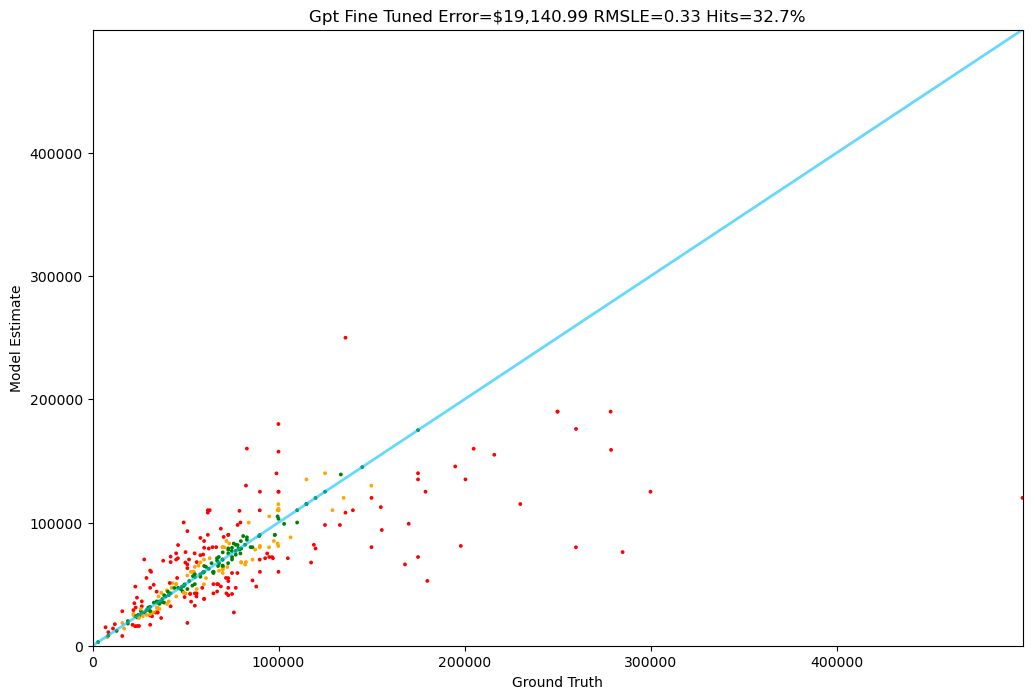

In [11]:
Tester.test(gpt_fine_tuned, test)

## Fine-tune GPT 4o on full training set

In [31]:
openai.fine_tuning.jobs.create(
    training_file=full_train_file.id,
    validation_file=full_val_file.id,
    model="gpt-4o-2024-08-06",
    seed=SEED,
    integrations = [wandb_integration],
    suffix="car-pricer"
)

FineTuningJob(id='ftjob-21JxTrpSjQk4C4BNGKAkSNnX', created_at=1740200611, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-AkXl4q84Ruq7dOOhZQyfb0eU', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-2eQUSvaCDjW4qzFADFPdBk', validation_file='file-9UPouNDPdqE6Sc3AH2MMhy', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-21JxTrpSjQk4C4BNGKAkSNnX'))], user_provided_suffix='car-pricer', method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 'auto'}}})

In [19]:
job_id = 'ftjob-21JxTrpSjQk4C4BNGKAkSNnX'
fine_tuned_model_name_full = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name_full

'ft:gpt-4o-2024-08-06:personal:car-pricer:B3d6BMQs'

In [6]:
# Testing block functions

# The prompt
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

# utility function to extract price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0


def gpt_4o_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name_full, 
        messages=messages_for(item),
        seed=SEED,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $104,995.00 Truth: $102,995.00 Error: $2,000.00 SLE: 0.00 Item: 1969 Chevrolet Camaro
2: Guess: $41,995.00 Truth: $39,995.00 Error: $2,000.00 SLE: 0.00 Item: 1967 Chevrolet Camaro
3: Guess: $12,000.00 Truth: $12,950.00 Error: $950.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
4: Guess: $159,995.00 Truth: $115,000.00 Error: $44,995.00 SLE: 0.11 Item: 1968 Chevrolet Camaro SS
5: Guess: $118,995.00 Truth: $125,000.00 Error: $6,005.00 SLE: 0.00 Item: 1967 Ford Mustang
6: Guess: $45,000.00 Truth: $65,000.00 Error: $20,000.00 SLE: 0.14 Item: 1966 Ford Mustang
7: Guess: $48,995.00 Truth: $57,995.00 Error: $9,000.00 SLE: 0.03 Item: 1967 Chevrolet Camaro
8: Guess: $49,500.00 Truth: $49,500.00 Error: $0.00 SLE: 0.00 Item: 1975 Ford Bronco
9: Guess: $59,994.00 Truth: $64,900.00 Error: $4,906.00 SLE: 0.01 Item: 1968 Chevrolet Camaro
10: Guess: $36,000.00 Truth: $36,000.00 Error: $0.00 SLE: 0.00 Item: 1967 Ford Bronco
11: Guess: $69,950.00 Truth: $44,950.00 Error: $25,000.00 SLE: 0.20 Item: 19

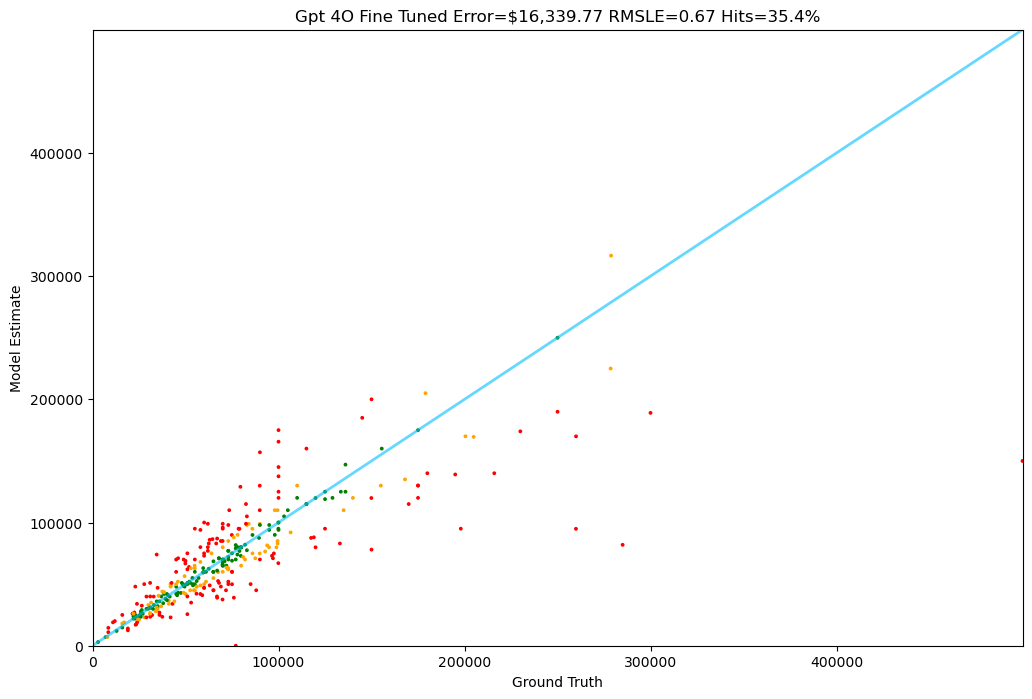

In [20]:
gpt_4o_full_results = Tester.test(gpt_4o_fine_tuned, test)